In [1]:
import os
import torch
import numpy as np
import pandas as pd

from PIL import Image
from torch import nn
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.transforms import ToPILImage, Grayscale, Normalize
import torchvision.datasets as datasets
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import time
import tarfile
from tqdm import tqdm
import tarfile

%matplotlib inline

In [2]:
sample_input1 = os.path.join(os.curdir,'..','..','data','preprocessed','autoencoder','val','CNV-9997680-73.jpeg')

In [3]:
sample_input2 = os.path.join(os.curdir,'..','..','data','preprocessed','autoencoder','train','NORMAL-1478754-6.jpeg')

In [4]:
img1 =  Image.open(sample_input1).convert('RGB')
img2 =  Image.open(sample_input2).convert('RGB')

In [5]:
transforms = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize([0.20041628,0.20041628,0.20041628],
             [0.20288454,0.20288454,0.20288454])
    ])

In [6]:
img1  = transforms(img1).unsqueeze(0)
img2  = transforms(img2).unsqueeze(0)

In [8]:
# Convolutional block defination
class ConvBlock(nn.Module):
    def __init__(self, **kwargs):
        super(ConvBlock, self).__init__()
        
        self.block = nn.Sequential(
                nn.Conv2d(**kwargs),
                nn.BatchNorm2d(num_features=kwargs['out_channels']),       
        )
        
    def forward(self,x):
        return self.block(x)
        

In [9]:
#Upsampling block definition
class ConvTransBlock(nn.Module):
    def __init__(self,relu = True, **kwargs):
        super(ConvTransBlock, self).__init__()
        
        self.relu = relu
        self.block = nn.Sequential(
                nn.ConvTranspose2d(**kwargs),
                nn.BatchNorm2d(num_features=kwargs['out_channels']),
                nn.ReLU(inplace=True) if self.relu else nn.Sigmoid()
        )
        
    def forward(self,x):
        return self.block(x)

In [10]:
# Residual block definition
class ResBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride = 1,downsample = False):
        super(ResBlock,self).__init__()
        
        self.block1 = ConvBlock(in_channels= in_channels,out_channels= out_channels, stride= stride,
                                kernel_size=3, padding = 1, bias= False)
        self.block2 = ConvBlock(in_channels= out_channels,out_channels= out_channels, stride= 1,
                               kernel_size= 3,padding = 1, bias = False)
        
        self.relu = nn.ReLU(inplace=True)
        
        if downsample:
            self.downsample = ConvBlock(in_channels=in_channels,out_channels= out_channels,
                                        kernel_size= 1, stride= 2, bias= False )
        else:
            self.downsample = None
        
        
        
        
    def forward(self, x):
        identity = x
        x = self.block1(x)
        x = self.relu(x)
        x = self.block2(x)
        
        if self.downsample != None:
            identity = self.downsample(identity)
        x += identity
        x = self.relu(x)
        
        return x

In [11]:
# Resnet34 Autoencoder
class ResnetAutoencoder(nn.Module):
    def __init__(self,res34=False):
        super(ResnetAutoencoder,self).__init__()
        
        self.res34 = res34
        self.same_layer = nn.MaxPool2d(kernel_size=1,stride=1)
        
        
        #Encoder
        
        #First block
        self.conv1 = ConvBlock(in_channels= 3, out_channels= 64, kernel_size= 7,
                        stride= 2, padding= 3, bias= False) 

        self.max_pool = nn.MaxPool2d(kernel_size= 3, stride= 2, padding=1)
        self.relu = nn.ReLU(inplace= True)
        
        #second block
        self.conv2_x = nn.Sequential(
                ResBlock(in_channels=64, out_channels=64, stride=1, downsample=False),
                ResBlock(in_channels=64, out_channels=64, stride=1, downsample=False),
                ResBlock(in_channels=64, out_channels=64, stride=1, downsample=False) 
                        if self.res34 else self.same_layer
        
        ) 
        
        #Third block
        self.conv3_x = nn.Sequential(
                ResBlock(in_channels=64, out_channels=128, stride=2, downsample=True),
                ResBlock(in_channels=128, out_channels=128, stride=1, downsample=False),
                ResBlock(in_channels=128, out_channels=128, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=128, out_channels=128, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
        )
        # Fourth Block
        self.conv4_x = nn.Sequential(
                ResBlock(in_channels=128, out_channels=256, stride=2, downsample=True),
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False),
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
                ResBlock(in_channels=256, out_channels=256, stride=1, downsample=False) 
                        if self.res34 else self.same_layer,
        )
        
        # Fifth block
        self.conv5_x = nn.Sequential(
                ResBlock(in_channels=256, out_channels=512, stride=2, downsample=True),
                ResBlock(in_channels=512, out_channels=512, stride=1, downsample=False),
                ResBlock(in_channels=512, out_channels=512, stride=1, downsample=False) 
                        if self.res34 else self.same_layer
        
        ) 
               
        
        #Decoder
        self.block6 = nn.Sequential(
                
                ConvTransBlock(in_channels= 512, out_channels = 256, kernel_size= 2, stride=2),
            
                ConvTransBlock(in_channels= 256, out_channels = 128, kernel_size= 2, stride=2),
                
                ConvTransBlock(in_channels= 128, out_channels = 64,  kernel_size= 2, stride=2),
            
                ConvTransBlock(in_channels= 64, out_channels = 64,   kernel_size= 2, stride=2),
                
                ConvTransBlock(in_channels= 64, out_channels = 3,    kernel_size= 2, stride=2,relu =False),        
        )
        

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.block6(x)
        return x

In [12]:
# Dataset class defination
class AEDataset(Dataset):
    def __init__(self, data_path, train=True ):
        if train :
            self.data_path = os.path.join(data_path, 'train')
        else:
            self.data_path = os.path.join(data_path, 'val')
        self.all_images = os.listdir(self.data_path)
        self.trasforms = transforms
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx)->torch.tensor:
        image_name = self.all_images[idx]
        path = os.path.join(self.data_path, image_name)
        return self.trasforms(Image.open(fp=path).convert('RGB'))

In [13]:
# model defination
model = ResnetAutoencoder(res34=True)

In [14]:
#model parameters count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,991,497 trainable parameters


In [15]:
#hyperparametres and setting
lr = 0.0001
batch_size = 16
epochs = 10
weight_decay=0.00001
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
criterion = nn.MSELoss()
schedular = optim.lr_scheduler.StepLR(optimizer, gamma=0.5,step_size=2,verbose=True)
scaler = torch.cuda.amp.GradScaler()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

Adjusting learning rate of group 0 to 1.0000e-04.


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/opt/conda/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [25]:
train_data_path = os.path.join(os.curdir,'..','..','data','preprocessed', 'autoencoder')
val_data_path = os.path.join(os.curdir,'..','..','data','preprocessed', 'autoencoder')
weights_path = os.path.join(os.curdir,'..','..','models','AE-weights')

In [19]:
# Data reading from the disk
train_data = AEDataset(train_data_path,train =True)
val_data = AEDataset(val_data_path,train =False)

In [20]:
# data loaders defination
train_iterator = DataLoader(train_data,shuffle = True, batch_size=batch_size)
val_iterator = DataLoader(val_data,shuffle = True, batch_size=batch_size)

In [21]:
# epoch time calculation function
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
# Mean and standard diciation for denormalization
mu = 0.20041628
sigma = 0.20288454

In [23]:
# training phase function defination
def train(model, iterator, optimizer, criterion, device,schedular ,scaler= False):
    print('training')
    
    epoch_loss = 0
    
    model.train()
    
    for image in tqdm(iterator):
        
        image = image.to(device)
        
        optimizer.zero_grad()
        
        # Automatic mixed precision option
        if scaler:
            
            with torch.cuda.amp.autocast():     
                
                output = model(image)
                image = (image * sigma) + mu 
                loss = criterion(image, output)
                assert output.dtype is torch.float16
        
        
        #float32 precision option         
        else:
            output = model(image)
            image = (image * sigma) + mu 
            loss = criterion(image, output)
        
        
        epoch_loss += loss.item()

        # Automatic mixed precision option
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        #float32 precision option 
        else:
            loss.backward()
            optimizer.step()
        
    schedular.step()

        
    return epoch_loss / len(iterator)

In [24]:
# evaluation phase function defination
def evaluate(model, iterator, criterion, device):
    print('validating')
    epoch_loss = 0

    
    model.eval()
    
    with torch.no_grad():
        
        for image in tqdm(iterator):

            image = image.to(device)

            output = model(image)

            image = (image * sigma) + mu 

            loss = criterion(image, output)

            epoch_loss += loss.item()

        
    return epoch_loss / len(iterator)

In [64]:
best_valid_loss = float('inf')
model_name = 'resnet34_autoencoder_weights.pt'
log = pd.DataFrame(columns=['train_loss' ,'val_loss'])

for epoch in range(epochs):
    
    start_time = time.monotonic()
    
    train_loss = train(model, train_iterator, optimizer, criterion,device, schedular,scaler=False)
    val_loss = evaluate(model, val_iterator, criterion, device)
        
    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), model_name)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    log.loc[len(log.index)] = [train_loss,val_loss]
    log.to_csv('log.csv')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s, current time: {time.ctime()}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {val_loss:.3f}')

In [27]:
model.load_state_dict(torch.load(weights_path + '/resnet34.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [66]:
x = model(img1).squeeze(0)
x = Grayscale()(x)
img1 = Grayscale()(img1)
img1 = img1*sigma +mu

In [67]:
x = ToPILImage()(x)
img1 = ToPILImage()(img1.squeeze(0))

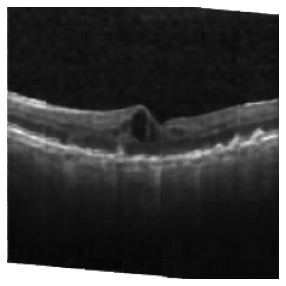

In [68]:
plt.figure(figsize=(5,5))
plt.imshow(x,cmap='gray')
plt.axis('off')
plt.savefig('AE-output')

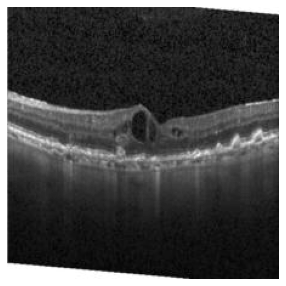

In [69]:
plt.figure(figsize=(5,5))
plt.imshow(img1,cmap='gray')
plt.axis('off')
plt.savefig('AE-input')

In [70]:
y = model(img2).squeeze(0)
y = Grayscale()(y)
img2 = Grayscale()(img2)
img2 = img2*sigma +mu

In [71]:
y= ToPILImage()(y)
img2 = ToPILImage()(img2.squeeze(0))

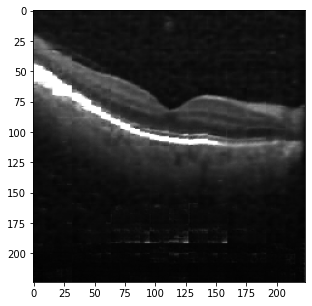

In [72]:
plt.figure(figsize=(5,5))
plt.imshow(y,cmap='gray')


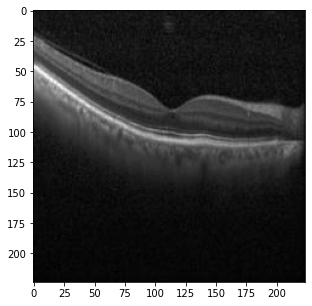

In [73]:
plt.figure(figsize=(5,5))
plt.imshow(img2,cmap='gray',)

In [28]:
log = pd.read_csv(weights_path + '/log.csv',index_col=0)

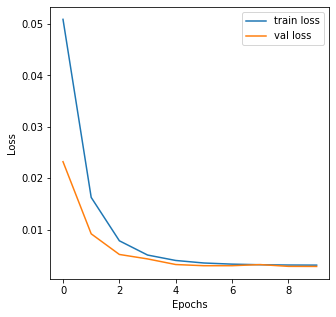

In [76]:
plt.figure(figsize=(5,5))
plt.plot(log.train_loss.to_list(), label='train loss')
plt.plot(log.val_loss.to_list(), label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('AE-loss-history')
plt.show()
